# CrossBee workflow notebook tutorial based on Python script modules for LBD

CrossBee is a system that recommends bridging terms (*b-terms*) through an ensemble-based ranking method. It aids experts in uncovering hidden connections between unrelated domains. CrossBee facilitates the ranking, exploration, and investigation of these cross-domain bridging terms.

<hr>

[2] Juršič, M., Cestnik, B., Urbančič, T., Lavrač, N. (2012a). Cross-domain Literature Mining: Finding Bridging Concepts with CrossBee, *Proceedings of the 3rd International Conference on Computational Creativity*, 33-40.

[3] Juršič, M., Cestnik, B., Urbančič, T., Lavrač, N. (2012b). Bisociative literature mining by ensemble heuristics. In M. R. Berthold (Ed.), *Bisociative Knowledge Discovery*, 338–358. Springer.

<hr>

Note that **our motive** was to **re-implement parts** of the tools such as **CrossBee**, RaJoLink and OntoGen so that we can generally **repeat the results** with the tools from the past experiments, and not so much to optimize the written Python code. The emphasis was on the reader's understanding of the learning processes and visualizing the workflows in terms of the repeatability of the results obtained; the efficiency and elegance of the programming was often saved for later stages.

Import and initialize `logging` library to track the execution of the scripts.

In [1]:
import logging

# Initialize logging with a basic configuration
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s: %(levelname)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S')

Implement: 
* Determine outlier documents (OntoGen)
* OK --- Draw ROC curve (CrossBee)
* Ensemble heuristics (CrossBee)

TODO:
* CrossBee (OK --- ROC in Ensemble, potential outliers)
* OntoGen (potential outliers)
* Domains:
    - Autism - Calcineurin (RaJoLink, CrossBee)
    - Alzheimer - Macrobiota (OntoGen, CrossBee)
    - Migraine - Magnesium (RaJoLink - Migraine, CrossBee, OntoGen)
    - Plant defense - Circadian rythm (???)

Import LBD components from the framework notebooks. The description of the individual components from the framework notebooks can be found in the respective notebooks. 

The purpose of the **import_ipynb** library is to enable the direct import of Jupyter notebooks as modules so that code, functions, and classes defined in one notebook can be easily reused in other notebooks or Python scripts.

In [2]:
import LBD_01_data_acquisition
import LBD_02_data_preprocessing
import LBD_03_feature_extraction
import LBD_04_text_mining
import LBD_05_results_analysis
import LBD_06_visualization

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bojan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bojan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Import additional Python libraries.

In [3]:
import nltk
import numpy as np
import itertools
import pandas as pd
import spacy
from typing import List, Dict

Define the name of the domains $C$ and $A$, then load the responding text from the file. The expected file format is as follows:

1. The file is encoded in Ascii (if it is in UTF-8 or other encoding, it should be converted to Ascii).
2. Each line in the file represents one document. The words in each document are separated by spaces. The length of the individual documents may vary.
3. The first word in each line is the **unique id**, followed by a semicolon. Normally **pmid** (pubmed id) can be used for this purpose. Or, as in this case of **autism-calcineurin** domains, simple count was used, due to historical reasons, to label the documents.
4. The second word in each line can optionally stand for a predefined domain (or class) of the document. In this case, the second word is preceded by **!**. For example, if the file contains documents that originate from two domains, e.g. *autism* and *calcineurin*, the second word in each line is either **!autism** or **!calcineurin**.
5. If the second word is not preceded by **!**, it will be considered the first word of the document. In this case, the document will be given the domain **!NA** (**not applicable** or **not available**).

**A background story for this experiment**

First, we selected *autism* and "calcineurin" as our domains of interest. 

Then we searched PubMed and collected 214 full-text documents on autism from the decade before 2006 in PubMed Central. After collecting the documents, we converted them from HTML and PDF format to plain text and made sure that each document was formatted consistently for further analysis. The 214 full text documents are stored in the file `input/Autism_Calcineurin.txt`.

We extracted around 2000 unique terms, focusing particularly on rare terms from the fields of amino acids, peptides and proteins to assess their potential relevance to autism research. Notable rare terms such as *lactoylglutathione*, *synaptophysin* and *calcium channels* appeared in our dataset.

The selected rare terms *lactoylglutathione*, *synaptophysin* and *calcium channels* prompted our team's autism expert to specifically investigate their associations with *calcineurin* (as it appeared as a joint term in all literatures of the selected rare terms). *Calcineurin* is a protein phosphatase with a high prevalence in the brain.

In [4]:
#domainName = 'Migraine-Magnesium'
#fileName = 'input/Magnesium_Migraine_before1988.txt'
#lines = LBD_01_data_acquisition.load_data_from_file(fileName)
#lines[:7]

In [10]:
domainName = 'Autism-Calcineurin'
fileName = 'input/Autism_Calcineurin.txt'
lines = LBD_01_data_acquisition.load_data_from_file(fileName)
lines[:7]

2024-09-13 18:19:53: INFO - Loaded 15243 lines from "input/Autism_Calcineurin.txt".


['1: !Autism The basis for the need for improved training and collaboration models in the field of autism is supported through historical background and literature in related fields. Ultimately, training specific to autism spectrum disorders and related evidence-based practices is proposed as necessary for all care providers having influence on programming related to this special population. It is also posited that the most effective avenue for training is through models incorporating more intensive and interactive training processes such as hands-on learning activities with opportunities for coaching, modeling, practice and feedback. Effective collaboration across systems (including home, medical, educational, and community settings) is emphasized to facilitate consistency in implementation of strategies for ultimate program success.\n',
 '2: !Autism Children diagnosed with autism or autism spectrum disorders (ASD) are more likely than other children to exhibit behaviors characteristi

In [6]:
domainName = 'Demo bow'
fileName = 'input/demo_bow.txt'
lines = LBD_01_data_acquisition.load_data_from_file(fileName)
lines[:7]

2024-09-13 18:19:31: INFO - Loaded 2 lines from "input/demo_bow.txt".


['11: John likes to watch movies. Mary likes movies too.\n',
 '12: John also likes to watch football games. Mary hates football.']

In [11]:
lines[9362:9369]

["9363: !Autism A report of two years' operation of a day-treatment center for autistic children is given. A brief historical review and a capsule summary regarding current concepts on autism are presented. The educational and treatment programs at the center are described, and two case vignettes illustrate the progress of the children. Highlights from group counseling sessions with the mothers of autistic children reveal the conflicts with which parents of disturbed children must deal. The two-year experience indicates that the identification of autism at an early age is crucial and that a day-treatment facility has much to offer the psychotic child and his parents.\n",
 '9364: !Autism The original papers by Kanner stressed the significance of psychogenic etiology rather than the possibility of an organic brain damage. In accord with recent literature the authors find in children suffering from this disturbance, who have been observed for several years, syndromes showing a certain deg

In [12]:
lines[-7:]

['15237: !Calcineurin Hydrophobic interaction chromatography is employed to determine if calmodulin might associate with its target enzymes such as cyclic nucleotide phosphodiesterase and calcineurin through its Ca2+-induced hydrophobic binding region. The majority of protein in a bovine brain extract that binds to a calmodulin-Sepharose affinity column also is observed to bind in a metal ion-independent manner to phenyl-Sepharose through hydrophobic interactions. Cyclic nucleotide phosphodiesterase activity that is bound to phenyl-Sepharose can be resolved into two activity peaks; one peak of activity is eluted with low ionic strength buffer, while the second peak eluted with an ethylene glycol gradient. Calcineurin bound tightly to the phenyl-Sepharose column and could only be eluted with 8 M urea. Increasing ethylene glycol concentrations in the reaction mixture selectively inhibited the ability of calmodulin to stimulate phosphodiesterase activity, suggesting that hydrophobic inter

Preprocess documents into a dictionary and extract documents as strings in a list. Might take a few minutes for longer files.

In [14]:
docs_dict = LBD_02_data_preprocessing.construct_dict_from_list(lines)

keep_list = []
remove_list = ['autism', 'calcineurin']
prep_docs_dict = LBD_02_data_preprocessing.preprocess_docs_dict(
    docs_dict, keep_list = keep_list, remove_list = remove_list, mesh_word_list = [], \
    cleaning = True, remove_stopwords = True, lemmatization = True, \
    min_word_length = 4, keep_only_nouns = True, keep_only_mesh = False, stemming = False, stem_type = None)

#prep_docs_dict = LBD_02_data_preprocessing.preprocess_docs_dict(
#    docs_dict, keep_list = keep_list, remove_list = remove_list, mesh_word_list = [], \
#    cleaning = True, remove_stopwords = False, lemmatization = True, \
#    min_word_length = 1, keep_only_nouns = False, keep_only_mesh = False, stemming = False, stem_type = None)

ids_list = LBD_02_data_preprocessing.extract_ids_list(prep_docs_dict)
prep_docs_list = LBD_02_data_preprocessing.extract_preprocessed_documents_list(prep_docs_dict)


2024-09-13 18:24:49: INFO - Text cleaning ...
2024-09-13 18:24:52: INFO - Removing stopwords ...
2024-09-13 18:24:52: INFO - Lematization ...
2024-09-13 18:24:58: INFO - Keeping only longer words (>= 4 characters)...
2024-09-13 18:24:59: INFO - Keeping only nouns ...
2024-09-13 18:28:50: INFO - Preprocessing finished.


Display the first dictionary items, document (pubmed) ids and preprocessed documents.

In [15]:
dict(itertools.islice(prep_docs_dict.items(), 7))

{'1': {'domain': 'Autism',
  'document': 'The basis for the need for improved training and collaboration models in the field of autism is supported through historical background and literature in related fields. Ultimately, training specific to autism spectrum disorders and related evidence-based practices is proposed as necessary for all care providers having influence on programming related to this special population. It is also posited that the most effective avenue for training is through models incorporating more intensive and interactive training processes such as hands-on learning activities with opportunities for coaching, modeling, practice and feedback. Effective collaboration across systems (including home, medical, educational, and community settings) is emphasized to facilitate consistency in implementation of strategies for ultimate program success.',
  'preprocessed': 'basis train collaboration model field background literature field spectrum disorder practice care provi

In [16]:
prep_docs_list[:7]

['basis train collaboration model field background literature field spectrum disorder practice care providers influence program population avenue train model train process handson activities opportunities coach model practice feedback collaboration systems home community settings consistency implementation strategies program success',
 'children diagnose spectrum disorder children exhibit behaviors feed sleep disorder parent children disorder health safety child sleep feed problems deal stress parent family members assessment treatment procedures address behavior problems sleep feed disorder article review literature assessment treatment recommendations service family members individuals feed sleep disorder',
 'behaviors individuals disabilities behaviors treatment target injury assessment function behaviors step treatment plan article background discussion assessment treatment behaviors readers perspective individuals disabilities',
 'skill deficits feature spectrum disorder skills co

Generate bag-of-words matrix from the list of preprocessed documents. Remove ngram words that occur less than *min_ngram_count* times (3 in our case) in the whole corpus of documents.

In [19]:
ngram_size = 1 # 3 for migraine
min_df = 1

# BOW representation
word_list, bow_matrix = LBD_03_feature_extraction.create_bag_of_words(prep_docs_list, ngram_size, min_df)
print('Number of terms in initial vocabulary with all ngrams: ', len(word_list))
# print(word_list)
# print(bow_matrix)

# remove nterms with frequency count less than min_count_ngram from vocabulary word_list and bow_matrix
min_count_ngram = 3 # 2 for migraine
tmp_sum_count_docs_containing_word = LBD_03_feature_extraction.sum_count_documents_containing_each_word(word_list, bow_matrix)

tmp_sum_count_word_in_docs = LBD_03_feature_extraction.sum_count_each_word_in_all_documents(word_list, bow_matrix)

tmp_filter_columns = []
for i, word in enumerate(word_list):
    if not LBD_03_feature_extraction.word_is_nterm(word):
        # if word in mesh_word_list:
        tmp_filter_columns.append(i)
    else:
        if tmp_sum_count_word_in_docs[word] >= min_count_ngram:
            tmp_filter_columns.append(i)

tmp_filter_rows = []
for i, id in enumerate(ids_list):
    tmp_filter_rows.append(i)

tmp_filtered_word_list, tmp_filtered_bow_matrix = LBD_03_feature_extraction.filter_matrix_columns(
    word_list, bow_matrix, tmp_filter_rows, tmp_filter_columns)

word_list = tmp_filtered_word_list
bow_matrix = tmp_filtered_bow_matrix
print('Number of terms in preprocessed vocabulary after removing infrequent ngrams: ', len(word_list))

LBD_02_data_preprocessing.save_list_to_file(word_list, "output/_list.txt")
LBD_02_data_preprocessing.save_list_to_file(prep_docs_list, "output/_prep_list.txt")


Number of terms in initial vocabulary with all ngrams:  34988
Number of terms in preprocessed vocabulary after removing infrequent ngrams:  34988


Compute margins for bag-of-word matrix. Prepare also the dictionaries of words and documents sorted according to the sum of word count in BoW matrix (*bow_matrix*)

In [20]:
sum_count_docs_containing_word = LBD_03_feature_extraction.sum_count_documents_containing_each_word(word_list, bow_matrix)

sum_count_word_in_docs = LBD_03_feature_extraction.sum_count_each_word_in_all_documents(word_list, bow_matrix)

sum_count_words_in_doc = LBD_03_feature_extraction.sum_count_all_words_in_each_document(ids_list, bow_matrix)

print('Number of documents in which each word is present: ', dict(itertools.islice(sum_count_docs_containing_word.items(), 7)))
print('Number of occurences of each word in all documents: ', dict(itertools.islice(sum_count_word_in_docs.items(), 7)))
print('Number of words in each document: ', dict(itertools.islice(sum_count_words_in_doc.items(), 7)))

# Compute the order of rows (documents) and columns (words) in the bow matrix so that the most frequent words are in the top-left corner. 
filter_columns = LBD_02_data_preprocessing.get_index_list_of_dict1_keys(
    LBD_02_data_preprocessing.sort_dict_by_value(sum_count_word_in_docs, reverse=True), word_list)
filter_rows = LBD_02_data_preprocessing.get_index_list_of_dict1_keys(
    LBD_02_data_preprocessing.sort_dict_by_value(sum_count_words_in_doc, reverse=True), ids_list) 

# Rearange (filter) the bow matrix according to the previously computed order.
filtered_ids_list, filtered_word_list, filtered_bow_matrix = LBD_03_feature_extraction.filter_matrix(
    ids_list, word_list, bow_matrix, filter_rows, filter_columns)
print('The first few documents in the rows of the filtered bow matrix: ', filtered_ids_list[:7])
print('The first few words in the columns of the filtered bow matrix: ', filtered_word_list[:7])

Number of documents in which each word is present:  {'0110micromoll': 1, '021s': 1, '028s': 1, '02min': 1, '05fold': 1, '072individual': 1, '10000s': 1}
Number of occurences of each word in all documents:  {'0110micromoll': 1, '021s': 1, '028s': 1, '02min': 1, '05fold': 1, '072individual': 1, '10000s': 1}
Number of words in each document:  {'1': 38, '2': 46, '3': 23, '4': 38, '5': 33, '6': 27, '7': 31}
The first few documents in the rows of the filtered bow matrix:  ['10387', '3894', '4059', '5073', '59', '2648', '4329']
The first few words in the columns of the filtered bow matrix:  ['children', 'study', 'disorder', 'patients', 'group', 'effect', 'protein']


Visualize bag-of-words matrix.

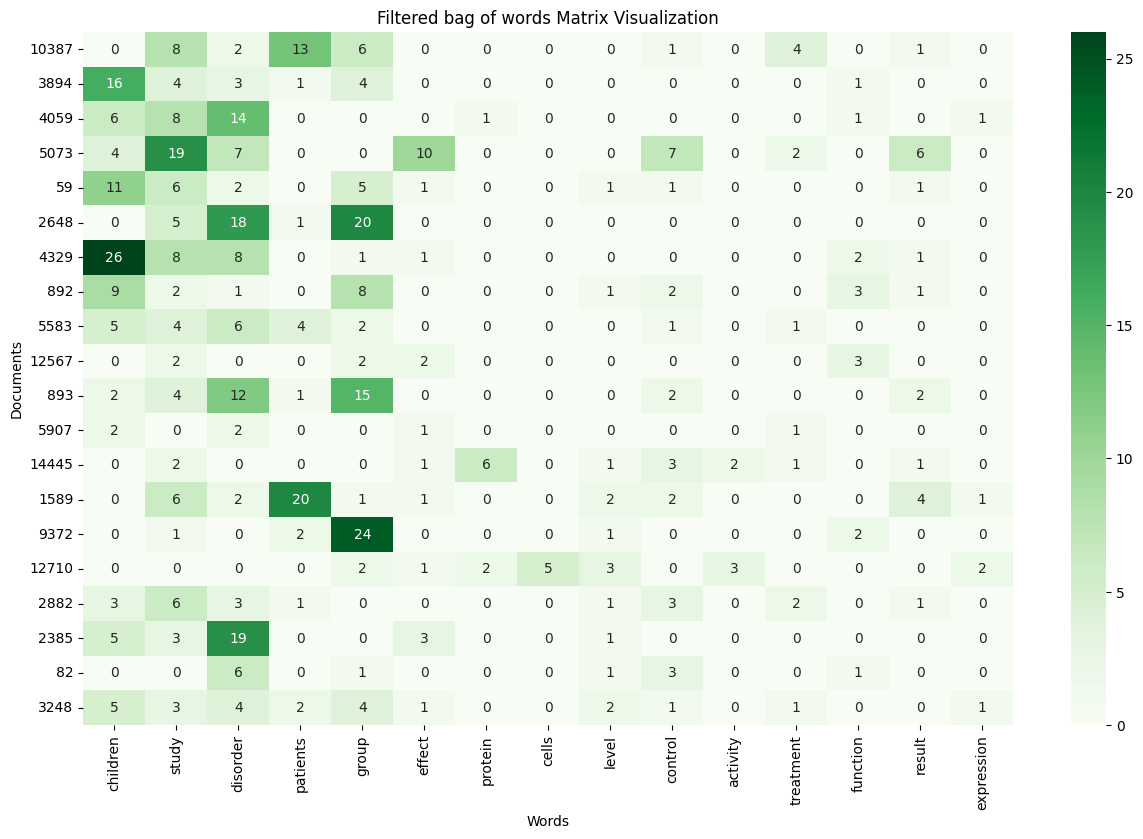

In [21]:
first_row = 0
last_row = 20
first_column = 0
last_column = 15
LBD_06_visualization.plot_bow_tfidf_matrix('Filtered bag of words', \
                                           filtered_bow_matrix[first_row:last_row,first_column:last_column], \
                                           filtered_ids_list[first_row:last_row], \
                                           filtered_word_list[first_column:last_column], as_int = True)

Generate tf-idf matrix from the list of preprocessed documents.

In [22]:
# TF-IDF representation
word_list, tfidf_matrix = LBD_03_feature_extraction.create_tfidf(prep_docs_list, ngram_size, min_df)
print('Number of terms in initial vocabulary with all ngrams: ', len(word_list))
# print(word_list)
# print(tfidf_matrix)

# Rearange (filter) the tfidf matrix according to the previously computed order from bow matrix.
tmp_filtered_word_list, tmp_filtered_tfidf_matrix = LBD_03_feature_extraction.filter_matrix_columns(
    word_list, tfidf_matrix, tmp_filter_rows, tmp_filter_columns)

word_list = tmp_filtered_word_list
tfidf_matrix = tmp_filtered_tfidf_matrix
print('Number of terms in preprocessed vocabulary after removing infrequent ngrams: ', len(word_list))

Number of terms in initial vocabulary with all ngrams:  34988
Number of terms in preprocessed vocabulary after removing infrequent ngrams:  34988


Compute margins for tf-idf matrix.

In [23]:
sum_word_tfidf = LBD_03_feature_extraction.sum_count_each_word_in_all_documents(word_list, tfidf_matrix)
max_word_tfidf = LBD_03_feature_extraction.max_tfidf_each_word_in_all_documents(word_list, tfidf_matrix)

sum_doc_tfidf = LBD_03_feature_extraction.sum_count_all_words_in_each_document(ids_list, tfidf_matrix)
max_doc_tfidf = LBD_03_feature_extraction.max_tfidf_all_words_in_each_document(ids_list, tfidf_matrix)

print('Sum of tf-idf for each word: ', dict(itertools.islice(sum_word_tfidf.items(), 7)))
print('Max of tf-idf for each word: ', dict(itertools.islice(max_word_tfidf.items(), 7)))

print('Sum of tf-idf for each document: ', dict(itertools.islice(sum_doc_tfidf.items(), 7)))
print('Max of tf-idf for each document: ', dict(itertools.islice(max_doc_tfidf.items(), 7)))

# Compute the order of rows (documents) and columns (words) in the tfidf matrix so that the most important words are in the top-left corner. 
filter_columns = LBD_02_data_preprocessing.get_index_list_of_dict1_keys(
    LBD_02_data_preprocessing.sort_dict_by_value(max_word_tfidf, reverse=True), word_list)
filter_rows = LBD_02_data_preprocessing.get_index_list_of_dict1_keys(
    LBD_02_data_preprocessing.sort_dict_by_value(max_doc_tfidf, reverse=True), ids_list) 

# Rearange (filter) the bow matrix according to the previously computed order.
filtered_ids_list, filtered_word_list, filtered_tfidf_matrix = LBD_03_feature_extraction.filter_matrix(
    ids_list, word_list, tfidf_matrix, filter_rows, filter_columns)

Sum of tf-idf for each word:  {'0110micromoll': 0.20663437281475872, '021s': 0.14648204911486157, '028s': 0.14648204911486157, '02min': 0.05803827767344634, '05fold': 0.13727224186318382, '072individual': 0.11755262764412579, '10000s': 0.18162209713916935}
Max of tf-idf for each word:  {'0110micromoll': 0.20663437281475872, '021s': 0.14648204911486157, '028s': 0.14648204911486157, '02min': 0.05803827767344634, '05fold': 0.13727224186318382, '072individual': 0.11755262764412579, '10000s': 0.18162209713916935}
Sum of tf-idf for each document:  {'1': 5.012278659871322, '2': 4.205201472113132, '3': 3.5258013482046717, '4': 4.9559190892794485, '5': 4.624036964635491, '6': 3.986601158703161, '7': 3.7299204311581833}
Max of tf-idf for each document:  {'1': 0.3578262044726624, '2': 0.5896355585649714, '3': 0.5600874346334463, '4': 0.45035539021654164, '5': 0.3575086480177052, '6': 0.4445410349803252, '7': 0.5382978160766094}


Visualize tf-idf matrix.

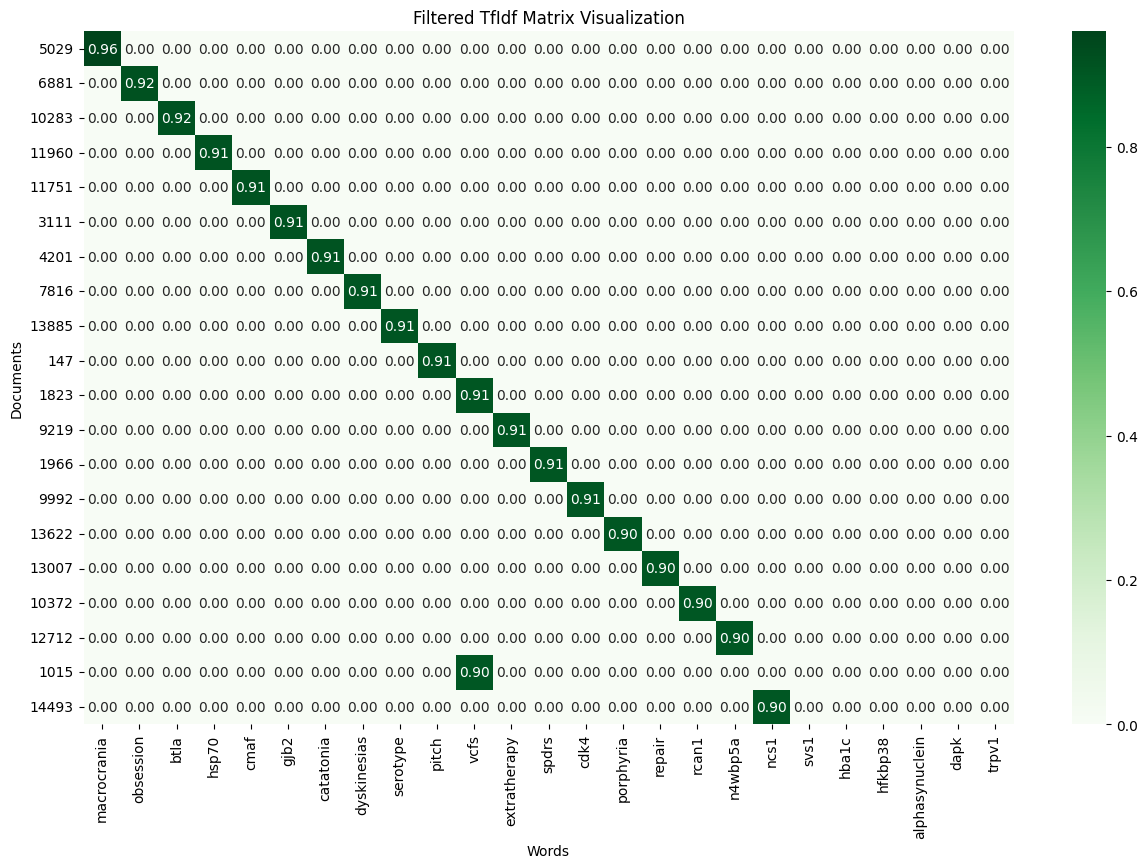

In [24]:
first_row = 0
last_row = 20
first_column = 0
last_column = 25
LBD_06_visualization.plot_bow_tfidf_matrix('Filtered TfIdf', filtered_tfidf_matrix[first_row:last_row,first_column:last_column], \
                                           filtered_ids_list[first_row:last_row], filtered_word_list[first_column:last_column], as_int = False)

Generate a list of the domain names of all the documents and a list of unique domain names.

In [25]:
domains_list = LBD_02_data_preprocessing.extract_domain_names_list(prep_docs_dict)
print('Domain names for the first few documents: ', domains_list[:7])
unique_domains_list = LBD_02_data_preprocessing.extract_unique_domain_names_list(prep_docs_dict)
print('A list of all uniques domain names in all the documents: ', unique_domains_list)

Domain names for the first few documents:  ['Autism', 'Autism', 'Autism', 'Autism', 'Autism', 'Autism', 'Autism']
A list of all uniques domain names in all the documents:  ['Autism', 'Calcineurin']


In [26]:
# Generate domains_bow_matrix from bow_matrix using domain_names list to add bow_matrix rows for each unique domain name into a single row
domains_bow_matrix = np.empty((0, bow_matrix.shape[1]))
no_documents_in_domain = {}
for i, domain_name in enumerate(unique_domains_list):
    domain_docs_indices = [i for i, label in enumerate(domains_list) if label == domain_name]
    no_documents_in_domain[domain_name] = len(domain_docs_indices)
    print(domain_docs_indices[:7])
    tmp = (bow_matrix[domain_docs_indices,:]).sum(axis=0)
    print(i, tmp)
    domains_bow_matrix = np.vstack((domains_bow_matrix, tmp))
    # Compute centroid for the current cluster
    #centroid_x = np.mean(pca_result[cluster_docs_indices, 0])
    #centroid_y = np.mean(pca_result[cluster_docs_indices, 1])
print(domains_bow_matrix)
print(no_documents_in_domain)

[0, 1, 2, 3, 4, 5, 6]
0 [0 0 0 ... 0 0 0]
[9365, 9366, 9367, 9368, 9369, 9370, 9371]
1 [1 1 1 ... 1 6 2]
[[0. 0. 0. ... 0. 0. 0.]
 [1. 1. 1. ... 1. 6. 2.]]
{'Autism': 9365, 'Calcineurin': 5878}


In [27]:
def cell_value_in_bow_matrix(bow_matrix, domain_name, word):
    """
    """
    line_idx = unique_domains_list.index(domain_name)
    column_idx = word_list.index(word)
    return(bow_matrix[line_idx, column_idx])

cell_value_in_bow_matrix(domains_bow_matrix, unique_domains_list[0], word_list[0])


0.0

In [37]:
import random
import time

# Seed the random number generator for better randomness
random.seed(time.time())  # Use current time to seed the generator

# Generate a random 7-digit number
random_number = random.randint(1000000, 9999999)

print("Dictionary of words, count and max(tfidf):")

max_word_tfidf_selected = {}
sum_word_tfidf_selected = {} 
aux_word_tfidf_selected = {} 
min_word_tfidf_selected = {} ### TODO from here on ...
for word in max_word_tfidf.keys():
    if sum_count_docs_containing_word[word] >= 1:
        passed = True
        for domain_name in unique_domains_list:
            if cell_value_in_bow_matrix(domains_bow_matrix, domain_name, word) <= 0:
                passed = False
        if passed:
            max_word_tfidf_selected[word] = max_word_tfidf[word]
            sum_word_tfidf_selected[word] = sum_word_tfidf[word]
            aux_word_tfidf_selected[word] = random.randint(1, 999999)
            min_word_tfidf_selected[word] = max_word_tfidf[word] * sum_word_tfidf[word]

# max_word_tfidf_selected = aux_word_tfidf_selected
# max_word_tfidf_selected = sum_word_tfidf_selected
# max_word_tfidf_selected = min_word_tfidf_selected

import itertools
print('All the words in vocabulary: ', len(max_word_tfidf))
print('Selected b-term candidate words: ', len(max_word_tfidf_selected), ' ', dict(itertools.islice(max_word_tfidf_selected.items(), 30)))

max_word_tfidf_selected_sorted = LBD_02_data_preprocessing.sort_dict_by_value(max_word_tfidf_selected, True)

print('Sorted b-term candidate words: ', len(max_word_tfidf_selected_sorted), ' ', dict(itertools.islice(max_word_tfidf_selected_sorted.items(), 30)))
print('The first and the last sorted b-term word: ', list(max_word_tfidf_selected_sorted.items())[0], ' ', list(max_word_tfidf_selected_sorted.items())[-1])
print('Mean value of max tf-idf values: ', np.array(list(max_word_tfidf_selected_sorted.values())).mean())

Dictionary of words, count and max(tfidf):
All the words in vocabulary:  34988
Selected b-term candidate words:  6122   {'100fold': 0.13306149670273734, '100microm': 0.12995505724903342, '12hr': 0.19273992369468024, '12th': 0.2707772025108404, '145trisphosphate': 0.2407985296583372, '15fold': 0.20987815314047314, '15min': 0.3238751272726699, '17year': 0.11296959270204106, '1950s': 0.25234969099033183, '1960s': 0.23654738448985962, '1970s': 0.33812465058278923, '1980s': 0.35027924627045326, '1990s': 0.3604285172646603, '1year': 0.19884452067656477, '21st': 0.1628179174021525, '22q112': 0.6863245819239601, '24bp': 0.17165283145679794, '24hr': 0.17394998922305338, '28day': 0.16513236533971237, '30min': 0.35618019905711323, '3day': 0.1988803080269417, '46fold': 0.12537381450961604, '4ebp1': 0.2152459993199779, '6month': 0.2392101450168585, '72hr': 0.15266798211419919, '7day': 0.2112757913052895, '95ci': 0.145171200560478, 'abandonment': 0.20143020919520216, 'abbreviate': 0.3547397307953261

In [38]:
sum_word_tfidf_selected

{'100fold': 0.7698647530805061,
 '100microm': 0.2583499012153305,
 '12hr': 0.5026433570151241,
 '12th': 1.019742879357679,
 '145trisphosphate': 3.5017600199335925,
 '15fold': 1.0375358769865994,
 '15min': 0.5231720763457242,
 '17year': 0.19042495002320525,
 '1950s': 1.2896298733031781,
 '1960s': 1.8703720974485119,
 '1970s': 2.8887457825329657,
 '1980s': 4.851810567887652,
 '1990s': 3.8230817486843423,
 '1year': 3.496665264768564,
 '21st': 0.30871670803482554,
 '22q112': 4.179664724798276,
 '24bp': 0.540846915931816,
 '24hr': 0.8629515257298903,
 '28day': 0.305619250500599,
 '30min': 0.9852351759765928,
 '3day': 0.6931643656717359,
 '46fold': 0.24359019529465023,
 '4ebp1': 0.5369352183502083,
 '6month': 0.35513935660289686,
 '72hr': 0.24557792531972705,
 '7day': 0.8882000939353392,
 '95ci': 0.5113660843519892,
 'abandonment': 0.4989578313512688,
 'abbreviate': 1.236845009029525,
 'abdomen': 0.9060676446164153,
 'aberrations': 9.058161660692459,
 'abilities': 49.029039443442976,
 'abili

In [39]:
bterms_list = list(max_word_tfidf_selected_sorted.keys())
bterms_list_length = len(bterms_list)

df = pd.DataFrame({'b-term': bterms_list, 'max tf-idf': list(max_word_tfidf_selected_sorted.values())})
df[0:45]

,b-term,max tf-idf
0,vcfs,0.906327
1,repair,0.903787
2,psoriasis,0.888768
3,trail,0.885305
4,caregivers,0.879413
5,aldosterone,0.878232
6,instruction,0.874098
7,bcl2,0.871731
8,s100b,0.871627
9,ghrh,0.871276


In [40]:
name = 'bcl2'
print(name, ': ', 'position in the list of rare terms ', list(max_word_tfidf_selected_sorted.keys()).index(name), ' (', len(max_word_tfidf_selected_sorted), \
      '), max tfidf: ', format(max_word_tfidf_selected_sorted[name], '.3f'), sep='')

bcl2: position in the list of rare terms 7 (6122), max tfidf: 0.872


In [41]:
petric_bterms = ["22q112", "deletion syndrome", "asbestos", "bcl2", "bombesin", "calmodulin", "radiation", \
                 "hypothyroxinemia", "synaptic", "synaptic plasticity", "type 1 diabetes", \
                 "ulcerative colitis", "working memory", \
                 "t17p22q21"]

petric_bterms = ["22q112", "deletion", "syndrome", "asbestos", "bcl2", "bombesin", "calmodulin", "radiation", \
                 "hypothyroxinemia", "synaptic", "plasticity", "diabetes", \
                 "colitis", "work", "memory", "t17p22q21"]
nn = 0
indb = []
size = len(max_word_tfidf_selected_sorted)
for name in petric_bterms:
    if name in max_word_tfidf_selected_sorted.keys():
       nn += 1
       position = list(max_word_tfidf_selected_sorted.keys()).index(name)
       indb.append(position)
       print(name, ': ', 'position in the list of potential bterms ', list(max_word_tfidf_selected_sorted.keys()).index(name), ' (', len(max_word_tfidf_selected_sorted), \
             '), max tfidf: ', format(max_word_tfidf_selected_sorted[name], '.3f'), ' part: ', format(position/size*100, '.1f'), sep='')
    else:
        print('NOT:', name, 'NOT in the list.')   
print(nn, len(petric_bterms))
print(indb)

22q112: position in the list of potential bterms 355 (6122), max tfidf: 0.686 part: 5.8
deletion: position in the list of potential bterms 271 (6122), max tfidf: 0.711 part: 4.4
syndrome: position in the list of potential bterms 57 (6122), max tfidf: 0.817 part: 0.9
asbestos: position in the list of potential bterms 219 (6122), max tfidf: 0.729 part: 3.6
bcl2: position in the list of potential bterms 7 (6122), max tfidf: 0.872 part: 0.1
bombesin: position in the list of potential bterms 3798 (6122), max tfidf: 0.278 part: 62.0
calmodulin: position in the list of potential bterms 369 (6122), max tfidf: 0.680 part: 6.0
radiation: position in the list of potential bterms 994 (6122), max tfidf: 0.553 part: 16.2
hypothyroxinemia: position in the list of potential bterms 5622 (6122), max tfidf: 0.171 part: 91.8
synaptic: position in the list of potential bterms 448 (6122), max tfidf: 0.660 part: 7.3
plasticity: position in the list of potential bterms 470 (6122), max tfidf: 0.657 part: 7.7
d

Missing and changed b-terms:

- maternal hypothyroxinemia -> hypothyroxinemia
- ulcerative colitis -> colitis
- t17p22q21 - found only in Autism documents

TODO: implement selected heuristics for bterm ranking

In [50]:
print(f'Size: {size}')
print(f'len(indb): {len(indb)}')
print()

pt = []
for i in range(size):
    pt.append(0)
for i in range(len(indb)):
    for j in range(indb[i], size):
        pt[j] += 1
print(pt)
suma = 0
part = 0
for i in range(size):
    if i % 100 == 0:
        print((i+1)/size*100.0, pt[i]/len(indb)*100.0)
    part += pt[i]
    suma += len(indb)
print(part/suma*100.0)

no_all_bterm_candidates = size
no_swansons_bterms = len(indb)

Size: 6122
len(indb): 15

[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5

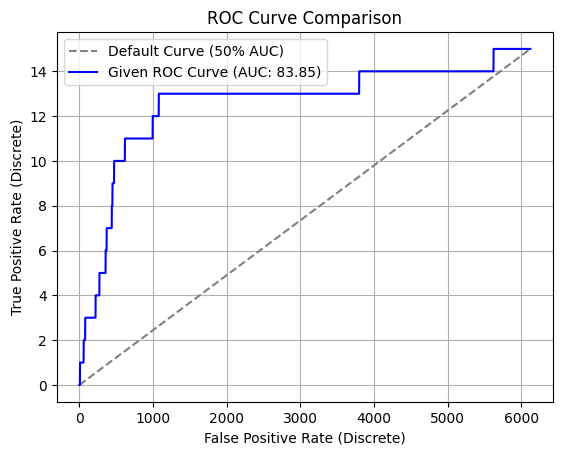

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Example ROC curve points (y-values), replace with the actual list of 120 numbers
roc_points = pt

# X-values for the ROC curve (0 to 120)
x_values = np.arange(0, no_all_bterm_candidates)

# Calculating the AUC for the given ROC curve using the trapezoidal rule
auc = np.trapz(roc_points, x_values) / (no_all_bterm_candidates*no_swansons_bterms) * 100  # Normalizing by the area of the full plot

# Plotting the default curve (50% AUC)
default_x = np.array([0, no_all_bterm_candidates])
default_y = np.array([0, no_swansons_bterms])
plt.plot(default_x, default_y, label='Default Curve (50% AUC)', linestyle='--', color='gray')

# Plotting the given ROC curve
plt.plot(x_values, roc_points, label=f'Given ROC Curve (AUC: {auc:.2f})', color='blue')

# Adding labels and legend
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate (Discrete)')
plt.ylabel('True Positive Rate (Discrete)')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()